# Predicting price of skincare products

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from sklearn import preprocessing
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet, 
                                  RidgeCV, LassoCV, ElasticNetCV)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.preprocessing import StandardScaler

### 1. Load dataframe

**see notebook part 2 on initial data cleaning**

In [2]:
skincare_df = pd.read_csv('skincare_products.csv')

In [3]:
print(skincare_df.shape)
skincare_df.sample(4)

(1847, 15)


,brand,productName,price_USD,rating_val,review_count,wordCount_descr,key_ingredients,ingredients_list,len_ingredients,len_actives,benefits_count,clean_formula,clinical,productType,size_float
659,mario badescu,mint lip balm,8.00,4.7,75.0,23,0.0,"['hydrogenated polydecene', ' cocoglycerides',...",37.0,7.0,4.0,0.0,0.0,moisturizer,0.35
209,cerave,skin renewing day cream spf 30,24.99,3.4,401.0,23,4.0,"['active: octinoxate 7.5 %', ' zinc oxide 10.5...",43.0,7.0,8.0,1.0,0.0,moisturizer,1.70
117,murad,essential-c day moisture broad spectrum spf 30...,68.00,4.4,207.0,17,3.0,"['active ingredients: octinoxate 7.5%', ' homo...",49.0,7.0,4.0,1.0,0.0,moisturizer,1.70
201,ulta,lip scrubber,8.00,4.7,51.0,22,0.0,none,0.0,0.0,0.0,0.0,0.0,moisturizer,1.00


## Analyze distribution of data set

Text(0.5, 1.0, 'Distribution of products prices')

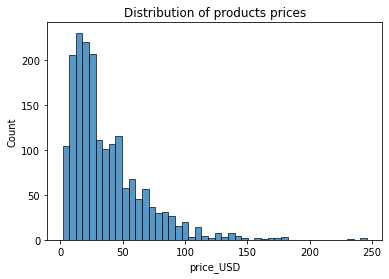

In [4]:
# distribution of predictor, price
plt.figure(figsize=[6,4])
sns.histplot(skincare_df['price_USD']).set_title('Distribution of products prices')

Text(0.5, 1.0, 'Distribution of products prices')

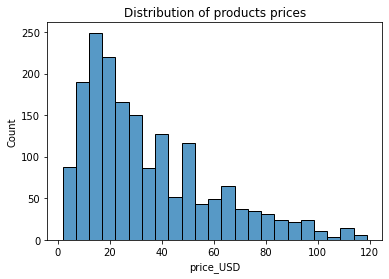

In [5]:
# only look at products < $120
mask_price = skincare_df[skincare_df['price_USD'] <= 120]

plt.figure(figsize=[6,4])
sns.histplot(mask_price['price_USD']).set_title('Distribution of products prices')

Text(0.5, 1.0, 'Distribution of reviews')

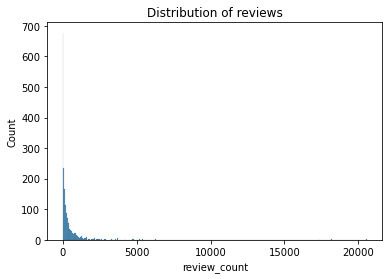

In [6]:
# distribution of review counts
plt.figure(figsize=[6,4])
sns.histplot(skincare_df['review_count']).set_title('Distribution of reviews')

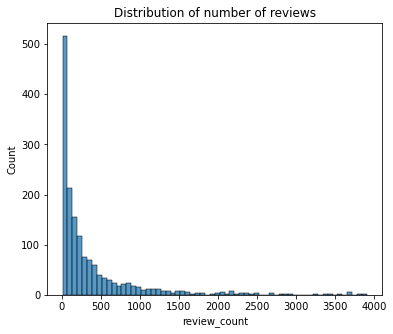

In [105]:
mask_rev_2 = skincare_df[(skincare_df['review_count'] < 4000) &\
                          (skincare_df['review_count'] >10)]

# subset distribution of reviews count
plt.figure(figsize=[6,5])
sns.histplot(mask_rev_2['review_count']).set_title('Distribution of number of reviews')
plt.savefig('reviews_distr.png')

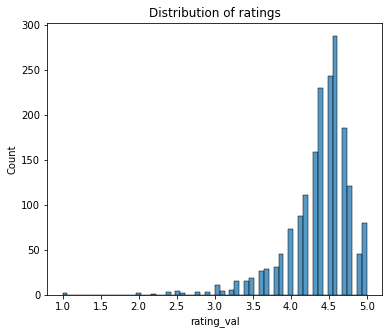

In [106]:
# rating distribution
plt.figure(figsize=[6,5])
sns.histplot(skincare_df['rating_val']).set_title('Distribution of ratings')
plt.savefig('ratings.png')

## Using subset of data

In [12]:
skincare_df2 = (skincare_df[(skincare_df['review_count'] < 4000) &
                            (skincare_df['review_count'] > 10) &
                            (skincare_df['price_USD'] <= 120) &
                            (skincare_df['len_ingredients'] >= 2)])

In [13]:
skincare_df2.shape

(1501, 15)

In [ ]:
plt.figure(figsize=[8,6])
sns.heatmap(skincare_df2.corr(), annot=True)

In [ ]:
sns.pairplot(skincare_df)

Somewhat correlation between len_ingredients and clinical features with price

## Initial linear regression model using OLS

In [14]:
# keep only numeric variables
#numerics 'int16', 'int32', 'int64', 'float16', 'float32', 'float64'
numerics = ['float64', 'int64']
skincare_sub = skincare_df2.select_dtypes(include=numerics)
y = skincare_sub['price_USD']
x = skincare_sub.drop(columns='price_USD')
X = sm.add_constant(x)

model = sm.OLS(y,X)
fit = model.fit()

r_squared = fit.rsquared
adjusted_r2 = fit.rsquared_adj
print('r_squared', round(r_squared, 3))
print('adjusted_r2', round(adjusted_r2, 3))
#fit.summary()

r_squared 0.281
adjusted_r2 0.277


## Features engineering

In [15]:
skincare_df2['rating_x2'] = skincare_df2.loc[:,'rating_val'] ** 2
skincare_df2['price_per_vol'] = skincare_df2['price_USD'] / skincare_df2['size_float']
skincare_df2 = pd.get_dummies(skincare_df2, columns=['productType'], drop_first=True)

/var/folders/rb/xjz9rwgx62s435ny2cx4kwk40000gn/T/ipykernel_52528/2841466215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skincare_df2['rating_x2'] = skincare_df2.loc[:,'rating_val'] ** 2
/var/folders/rb/xjz9rwgx62s435ny2cx4kwk40000gn/T/ipykernel_52528/2841466215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skincare_df2['price_per_vol'] = skincare_df2['price_USD'] / skincare_df2['size_float']


In [16]:
not_clean_list = (['ethyl methacrylate', 'methyl methacrylate', 'aluminum salts', 
                   'benzophenone-1', 'benzophenone-2', 'butoxyethanol', 
                   'butylated hydroxyanisole', 'bht', 'carbon black', 'dea', 'mea', 
                   'tea', 'formaldehyde', 'hydroquinone', 'mineral oil', 'paraffin', 
                   'parabens', 'pfas', 'pfoa', 'pfos', 'phthalates', 'resorcinol', 
                   'styrene', 'styrene oxide', 'talc', 'triclosan','citrus aurantium dulcis (orange) peel oil'])

def find_ingredient(name_ingr):    
    for i in not_clean_list:
        if i in name_ingr:
            return 0
    return 1

a = skincare_df2['ingredients_list'].apply(find_ingredient)
skincare_df2['cleanXformula'] = a*skincare_df2['clean_formula']

In [17]:
# feature engineer brand, brand with smallest range in pricing
ten_brands = (['chapstick','wet n wild','essence','dionis','belif','the crème shop',
               'the route','covergirl','manna kadar beauty','good molecules'])

brands_type = skincare_df2['brand'].values
other_brands = list(set(brands_type) - set(ten_brands))

skincare_df2['brand_sub'] = skincare_df2['brand'].replace(other_brands,'other')
skincare_df2['brand_sub2'] = skincare_df2['brand_sub'].apply(lambda x: 0 if x == 'other' else 1)

# selecting most common ingredients from ingredients list
skincare_df2['glycerin'] = (skincare_df2['ingredients_list']
                            .apply(lambda x: 1 if 'glycerin' in x else 0))

skincare_df2['dimethicone'] = (skincare_df2['ingredients_list']
                               .apply(lambda x: 1 if 'dimethicone' in x else 0))

skincare_df2['niacinamide'] = (skincare_df2['ingredients_list']
                               .apply(lambda x: 1 if 'niacinamide' in x else 0))

skincare_df2['glycolic acid'] = (skincare_df2['ingredients_list']
                                 .apply(lambda x: 1 if 'glycolic acid' in x else 0))

skincare_df2['peptide'] = (skincare_df2['ingredients_list']
                           .apply(lambda x: 1 if 'peptide' in x else 0))

In [18]:
# select columns with numerics for modeling
numerics = ['float64', 'int64','uint8']
feature_df = skincare_df2.select_dtypes(include=numerics)

In [19]:
len(feature_df.columns)

21

## Linear regression with OLS on new features

In [20]:
# drop columns where p < 0.05
y = feature_df['price_USD']
x = feature_df.drop(columns = ['price_USD','clean_formula',\
                               'review_count','rating_val'])
X = sm.add_constant(x)

model = sm.OLS(y,X)
fit = model.fit()
r_squared = fit.rsquared
adjusted_r2 = fit.rsquared_adj
print('r_squared', round(r_squared, 3))
print('adjusted_r2', round(adjusted_r2, 3))

r_squared 0.443
adjusted_r2 0.437


In [108]:
feature_df.shape

(1501, 21)

In [22]:
a = fit.pvalues
for i, val in a.items():
    if val >0.05:
        print(i, round(val,3))

cleanXformula 0.076
glycolic acid 0.066


In [23]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_USD   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     69.50
Date:                Tue, 19 Apr 2022   Prob (F-statistic):          1.15e-174
Time:                        19:37:19   Log-Likelihood:                -6507.9
No. Observations:                1501   AIC:                         1.305e+04
Df Residuals:                    1483   BIC:                         1.315e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                15.0415      5.738      2.621      0.009       3.786      26.297
wordCount_descr      -0.1526      0.057     -2.680      0.007      -0.264      -0.041
key_ingredients       0.4733      0.236      2.002      0.045       0.010       0.937
len_ingredients       0.4791      0.041     11.610      0.000       0.398       0.560
len_actives          -3.3086      0.671     -4.932      0.000      -4.625      -1.993
benefits_count        0.4320      0.138      3.123      0.002       0.161       0.703
clinical              1.4984      0.250      5.990      0.000       1.008       1.989
size_float            0.7687      0.093      8.255      0.000       0.586       0.951
rating_x2             0.5725      0.164      3.499      0.000       0.252       0.893
price_per_vol         0.2715      0.016     16.936      0.000       0.240       0.303
productType_serum     5.2029      1.112      4.678      0.000       3.021       7.384
cleanXformula        -0.3645      0.205     -1.774      0.076      -0.767       0.039
brand_sub2           -6.9184      2.737     -2.528      0.012     -12.287      -1.550
glycerin              3.6681      1.345      2.728      0.006       1.031       6.306
dimethicone           5.4102      1.100      4.917      0.000       3.252       7.569
niacinamide          -5.1606      1.502     -3.436      0.001      -8.107      -2.214
glycolic acid         4.0026      2.174      1.841      0.066      -0.262       8.267
peptide               2.8370      1.383      2.051      0.040       0.124       5.550
==============================================================================
Omnibus:                      162.332   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1318.181
Skew:                          -0.072   Prob(JB):                    5.76e-287
Kurtosis:                       7.589   Cond. No.                         730.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# 10-30 indicate a mediocre multicollinearity
# values > 30 indicate strong multicollinearity.
vif = pd.DataFrame()
vif['variables'] = x.columns
vif['vif'] =[variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print(vif[vif['vif'] >10])

         variables        vif
0  wordCount_descr  10.600622
3      len_actives  40.476863
7        rating_x2  29.688001


<AxesSubplot:>

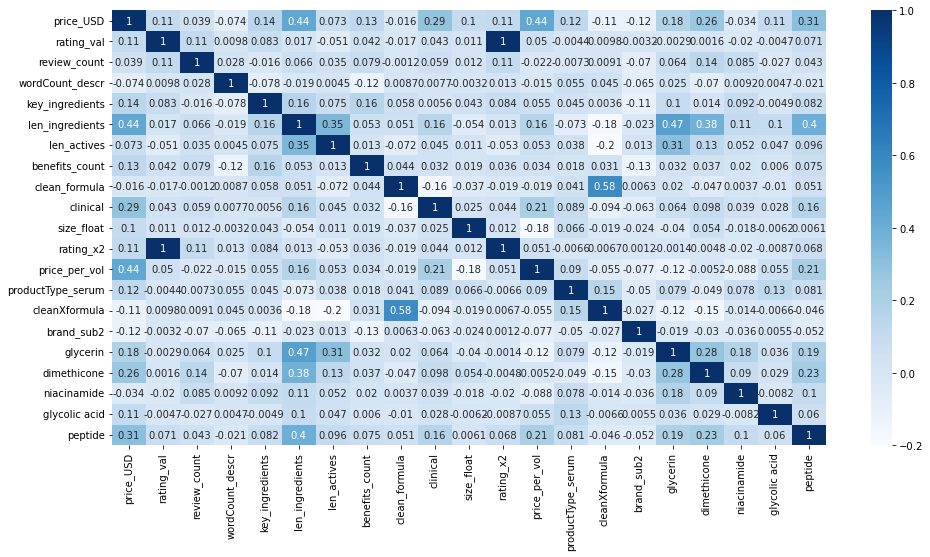

In [99]:
plt.figure(figsize=[16,8])
sns.heatmap(feature_df.corr(), annot=True, cmap='Blues')

In [100]:
feature_df.corr()

,price_USD,rating_val,review_count,wordCount_descr,key_ingredients,len_ingredients,len_actives,benefits_count,clean_formula,clinical,...,rating_x2,price_per_vol,productType_serum,cleanXformula,brand_sub2,glycerin,dimethicone,niacinamide,glycolic acid,peptide
price_USD,1.000000,0.107952,0.038558,-0.074149,0.143976,0.435855,0.072785,0.126949,-0.016349,0.287153,...,0.111402,0.438178,0.124495,-0.113471,-0.115196,0.176267,0.259894,-0.033785,0.106396,0.310450
rating_val,0.107952,1.000000,0.114047,0.009807,0.083080,0.017066,-0.051068,0.041958,-0.016591,0.043106,...,0.996626,0.049651,-0.004435,0.009806,-0.003189,-0.002940,0.001601,-0.019524,-0.004732,0.071276
review_count,0.038558,0.114047,1.000000,0.027503,-0.016421,0.066046,0.035445,0.079044,-0.001168,0.059437,...,0.108241,-0.022206,-0.007324,0.009084,-0.069874,0.063579,0.140631,0.084792,-0.026582,0.043490
wordCount_descr,-0.074149,0.009807,0.027503,1.000000,-0.078258,-0.018760,0.004549,-0.118687,0.008734,0.007700,...,0.012789,-0.014999,0.054914,0.044826,-0.065001,0.025477,-0.069869,0.009198,0.004734,-0.021285
key_ingredients,0.143976,0.083080,-0.016421,-0.078258,1.000000,0.160166,0.075236,0.158586,0.058314,0.005575,...,0.083720,0.054974,0.044681,0.003583,-0.107693,0.103682,0.014156,0.091709,-0.004862,0.081930
len_ingredients,0.435855,0.017066,0.066046,-0.018760,0.160166,1.000000,0.345303,0.053071,0.051445,0.160401,...,0.012680,0.162672,-0.072788,-0.181685,-0.022866,0.471492,0.384235,0.107643,0.103790,0.399299
len_actives,0.072785,-0.051068,0.035445,0.004549,0.075236,0.345303,1.000000,0.013480,-0.071614,0.044993,...,-0.053044,0.053039,0.037684,-0.200289,0.013446,0.313508,0.127688,0.051812,0.047220,0.096137
benefits_count,0.126949,0.041958,0.079044,-0.118687,0.158586,0.053071,0.013480,1.000000,0.044333,0.031800,...,0.035847,0.033780,0.017667,0.030915,-0.133189,0.031953,0.036550,0.019849,0.006009,0.074815
clean_formula,-0.016349,-0.016591,-0.001168,0.008734,0.058314,0.051445,-0.071614,0.044333,1.000000,-0.163919,...,-0.018722,-0.019331,0.041395,0.577911,0.006291,0.019912,-0.047003,0.003737,-0.010247,0.050501
clinical,0.287153,0.043106,0.059437,0.007700,0.005575,0.160401,0.044993,0.031800,-0.163919,1.000000,...,0.043538,0.210922,0.088827,-0.093596,-0.062653,0.063928,0.098398,0.038944,0.027966,0.164532


## Cross validation test

In [26]:
y = feature_df['price_USD']
x = feature_df.drop(columns = ['price_USD','clean_formula','review_count','rating_val'])

# split data
# hold 20% of data for final testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [27]:
# calculate scores and errors with input of model type
# testing with cross validation
def cv_model_scores(model_name):
    
    # split train data in 5 folds using kf
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # for simple linear regression model
    if model_name == 'simple':
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        #train scores
        r2_train = cross_val_score(model, X_train, y_train, cv= kf, scoring='r2')
        r2_train_mean = np.mean(r2_train)
        error = np.std(r2_train)
        
        # test scores
        r2_test = model.score(X_test, y_test)
        y_test_pred = model.predict(X_test)
        MAE = mean_absolute_error(y_test, y_test_pred)
        
    if model_name != 'simple':
        # Standardize data for regularization with scalar
        std = StandardScaler()

        # scale train, val, and test data
        X_train_scaled = std.fit_transform(X_train.values)
        X_test_scaled = std.transform(X_test.values)

        # tune optimal lambda
        alphas = 10**np.linspace(-2,2,200)
        
        if model_name == 'ridge':
            model = RidgeCV(alphas=alphas, cv=5)

        if model_name == 'lasso':
            model = LassoCV(alphas=alphas, cv=5)

        if model_name == 'elastic':
            l1_rats = [.1, .5, .7, .9, .95, .99, 1]
            model = ElasticNetCV(alphas=alphas, l1_ratio=l1_rats, cv=5, random_state=42)
    
        # train scores
        model.fit(X_train_scaled, y_train)
        # check scaled data?
        r2_train = cross_val_score(model, X_train_scaled, y_train, cv= kf, scoring='r2')
        r2_train_mean = np.mean(r2_train)
        error = np.std(r2_train)
        
        # test scores
        r2_test = model.score(X_test_scaled, y_test)
        y_test_pred = model.predict(X_test_scaled)
        MAE = mean_absolute_error(y_test, y_test_pred)

    print(model_name, 'regression scores:')
    print('train r2', r2_train)
    print('mean cv r2 {} +/- {}'.format(round(r2_train_mean,3), round(error,3)))
    print("test r2:", round(r2_test, 3))
    print("MAE +- $:", round(MAE, 2)) 

In [28]:
models_list = ['simple','ridge','lasso','elastic']
for i in models_list:
    cv_model_scores(i)
    print(" ")

simple regression scores:
train r2 [0.39054358 0.41968104 0.37822006 0.52167151 0.33326757]
mean cv r2 0.409 +/- 0.063
test r2: 0.413
MAE +- $: 13.66
 
ridge regression scores:
train r2 [0.39237975 0.43186739 0.36834842 0.51323988 0.3546437 ]
mean cv r2 0.412 +/- 0.057
test r2: 0.409
MAE +- $: 13.78
 
lasso regression scores:
train r2 [0.39058034 0.42079321 0.37841136 0.52173008 0.33252066]
mean cv r2 0.409 +/- 0.063
test r2: 0.413
MAE +- $: 13.66
 
elastic regression scores:
train r2 [0.39187371 0.43534027 0.36727406 0.5114768  0.35664375]
mean cv r2 0.413 +/- 0.056
test r2: 0.408
MAE +- $: 13.81
 


## Diagnostic plots and coefficients

In [29]:
def diagnostic_plot(y_train, y_test, y_pred_train, y_pred_test, res):
    plt.figure(figsize=(12,12))

    # residuals plot
    title_s = 14
    size=12
    plt.subplot(2,2,1)
    plt.title("Residuals plot", size=title_s, weight='bold')
    plt.xlabel("Predictions", size=size)
    plt.ylabel("Residuals", size=size)
    plt.scatter(y_pred_train, res, alpha=0.5)
    plt.plot([0,max(y_pred_train)], [0, 0], color='red', linestyle='--') 

    # QQ plot
    plt.subplot(2,2,2)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot", weight='bold')
    
    # scatter plot train set actual vs predicted
    plt.subplot(2,2,3)
    ticks = range(0,161,20)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title("Actual vs predicted on train set", weight='bold', size=title_s)
    plt.xlabel("Predicted price $", size=size)
    plt.ylabel("Actual price $", size=size)    
    plt.scatter(y_pred_train, y_train, alpha=0.5)
    plt.plot([0,160], [0,160], color='red', linestyle='--')
                    
    # scatter plot test set actual vs predicted
    plt.subplot(2,2,4)
    ticks = range(0,161,20)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title("Actual vs predicted price on test set", weight='bold', size=title_s)
    plt.xlabel("Predicted price $", size=size)
    plt.ylabel("Actual price $", size=size)    
    plt.scatter(y_pred_test, y_test, alpha=0.5)
    plt.plot([0,160], [0,160], color='red', linestyle='--')

In [30]:
y = feature_df['price_USD']
x = feature_df.drop(columns = ['price_USD','clean_formula','review_count','rating_val'])

# split data
# hold 20% of data for final testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

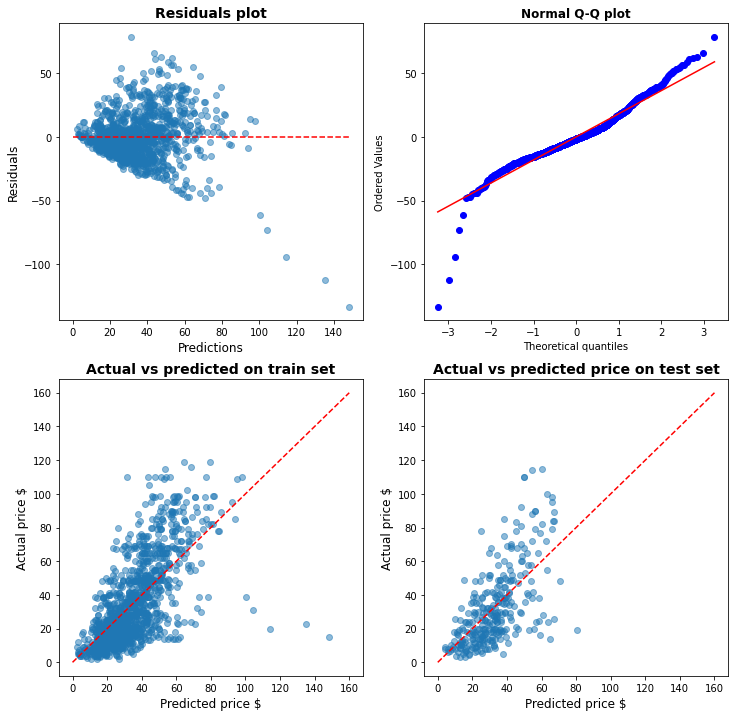

In [31]:
# linear regression
lm = LinearRegression()
lm.fit(X_train, y_train)
coef_lm = pd.DataFrame(list(zip(X_train.columns, lm.coef_)), columns=['name', 'coef'])
coef_lm['coef'] = coef_lm['coef'].apply(lambda x: round(x,2))

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)
res = y_train - y_pred_train

linear_plots = diagnostic_plot(y_train, y_test, y_pred_train, y_pred_test, res)
plt.savefig('simple_model_plots.png')

In [58]:
coef_lm['abs_coef'] = coef_lm['coef'].apply(lambda x: abs(x))
coef_lm = coef_lm.sort_values(by='abs_coef')

In [61]:
coef_lm

,name,coef,abs_coef
0,wordCount_descr,-0.17,0.17
8,price_per_vol,0.25,0.25
1,key_ingredients,0.32,0.32
10,cleanXformula,-0.36,0.36
4,benefits_count,0.42,0.42
2,len_ingredients,0.49,0.49
7,rating_x2,0.57,0.57
6,size_float,0.76,0.76
5,clinical,1.55,1.55
16,peptide,2.87,2.87


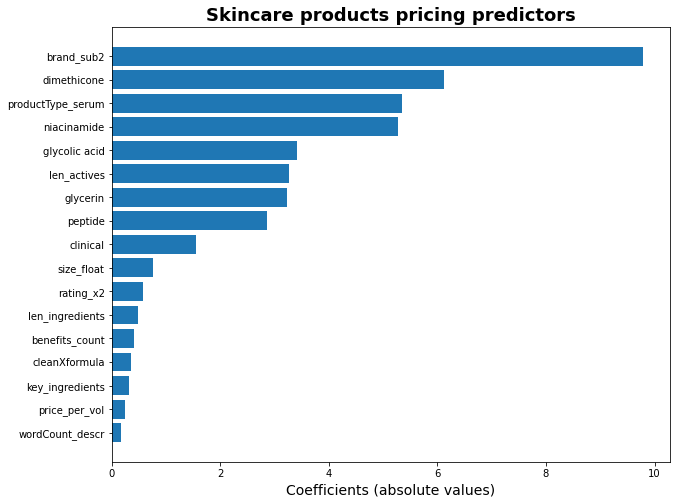

In [97]:
plt.figure(figsize=(10,8))
x= coef_lm['name']
y=coef_lm['abs_coef']
plt.barh(x,y)
plt.yticks(size=10)
plt.title('Skincare products pricing predictors', weight='bold', size=18)
plt.xlabel('Coefficients (absolute values)', size=14)
plt.savefig('coefficients.png')

Lasso model

In [32]:
# lasso 
std = StandardScaler()

# scale train, val, and test data
X_train_scaled = std.fit_transform(X_train.values)
alphas = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_train_scaled, y_train)

coef_lasso = pd.DataFrame(list(zip(X_train.columns, lasso_model.coef_)), columns=['name', 'coef'])
coef_lasso['coef'] = coef_lasso['coef'].apply(lambda x: round(x,2))

In [33]:
coef_combined = pd.merge(coef_lm, coef_lasso, on='name', how='outer', suffixes =['_simple','_lasso'])
coef_combined

,name,coef_simple,coef_lasso
0,wordCount_descr,-0.17,-1.38
1,key_ingredients,0.32,0.68
2,len_ingredients,0.49,7.74
3,len_actives,-3.27,-2.47
4,benefits_count,0.42,1.48
5,clinical,1.55,3.26
6,size_float,0.76,4.33
7,rating_x2,0.57,1.66
8,price_per_vol,0.25,8.77
9,productType_serum,5.35,2.44
